<a href="https://colab.research.google.com/github/sukhpreet111/MENTAL_HEALTH_PREDICTION/blob/main/mental_health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import joblib

In [48]:
df = pd.read_csv("https://raw.githubusercontent.com/sukhpreet111/MENTAL_HEALTH_PREDICTION/refs/heads/main/Mental%20Health%20in%20Tech%20Survey%20dataset%20CSV.csv")

In [49]:
df.head()

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,benefits,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,37,Female,United States,NaN,No,Yes,Often,Jun-25,No,Yes,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,44,M,United States,NaN,No,No,Rarely,More than 1000,No,Don't know,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,32,Male,Canada,NaN,No,No,Rarely,Jun-25,No,No,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,31,Male,United Kingdom,NaN,Yes,Yes,Often,26-100,No,No,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,31,Male,United States,NaN,No,No,Never,100-500,Yes,Yes,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Age                        1259 non-null   int64 
 1   Gender                     1259 non-null   object
 2   Country                    1259 non-null   object
 3   self_employed              1241 non-null   object
 4   family_history             1259 non-null   object
 5   treatment                  1259 non-null   object
 6   work_interfere             995 non-null    object
 7   no_employees               1259 non-null   object
 8   remote_work                1259 non-null   object
 9   benefits                   1259 non-null   object
 10  care_options               1259 non-null   object
 11  wellness_program           1259 non-null   object
 12  seek_help                  1259 non-null   object
 13  anonymity                  1259 non-null   object
 14  leave   

In [51]:
df.isnull().sum()

,0
Age,0
Gender,0
Country,0
self_employed,18
family_history,0
treatment,0
work_interfere,264
no_employees,0
remote_work,0
benefits,0


In [52]:
#for col in df.columns:
   #print(f"\n--- Value counts for '{col}' ---")
   #print(df[col].value_counts(dropna=False))

In [53]:
def classify_gender(g):
    g = str(g).strip().lower()

    male_keywords = ['male', 'm', 'man', 'maile', 'msle', 'mal', 'malr', 'cis male', 'male (cis)', 'cis man']
    female_keywords = ['female', 'f', 'woman', 'femake', 'femail', 'cis female', 'female (cis)', 'trans woman', 'trans-female']

    if any(kw in g for kw in male_keywords):
        return 'Male'
    elif any(kw in g for kw in female_keywords):
        return 'Female'
    else:
        return 'Other'

# Apply function to create a new normalized gender column
df['Gender_Normalized'] = df['Gender'].apply(classify_gender)

# Check the cleaned value counts
print(df['Gender_Normalized'].value_counts())


Gender_Normalized
Male      1192
Female      54
Other       13
Name: count, dtype: int64


In [54]:
df['Age'] = pd.to_numeric(df['Age'].astype(str).str.strip(), errors='coerce')

# Keep only realistic ages between 18 and 65(since 65 is retiremnet age)
df = df[(df['Age'] >= 18) & (df['Age'] <= 65)]

In [55]:
df['Age_log'] = np.log1p(df['Age']) #to solve class imbalance problem during modelling

<ipython-input-55-3bf59ac1a2d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age_log'] = np.log1p(df['Age']) #to solve class imbalance problem during modelling


In [56]:
# Drop 'Gender' and 'comments' columns
df.drop(['Age','Gender', 'comments','Country'], axis=1, inplace=True)

<ipython-input-56-788a615e85da>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Age','Gender', 'comments','Country'], axis=1, inplace=True)


In [57]:
# Fill missing values with 'Unknown'
df['self_employed'].fillna('Unknown', inplace=True)
df['work_interfere'].fillna('Unknown', inplace=True)

<ipython-input-57-31c78541884a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['self_employed'].fillna('Unknown', inplace=True)
<ipython-input-57-31c78541884a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['self_employed'].fillna('Unknown', inplace=True)
<ipython-input-57-31c78541884a>:3: FutureWarning: A value is trying to be set o

In [58]:
df.isnull().sum()

,0
self_employed,0
family_history,0
treatment,0
work_interfere,0
no_employees,0
remote_work,0
benefits,0
care_options,0
wellness_program,0
seek_help,0


In [59]:
# Define 'at_risk' condition
df['at_risk'] = (
    (df['treatment'] == 'Yes') |
    (df['work_interfere'].isin(['Often', 'Sometimes'])) |
    (df['family_history'] == 'Yes') |
    (df['mental_health_consequence'].isin(['Yes', 'Maybe']))
)

# Convert Boolean to label
df['at_risk'] = df['at_risk'].map({True: 'Yes', False: 'No'})

# Check distribution of risk
print(df['at_risk'].value_counts())


at_risk
Yes    1046
No      204
Name: count, dtype: int64


<ipython-input-59-61dd603f1bed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['at_risk'] = (
<ipython-input-59-61dd603f1bed>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['at_risk'] = df['at_risk'].map({True: 'Yes', False: 'No'})


In [60]:
# Create 'aware' column
df['aware'] = (
    (df['benefits'] == 'Yes') |
    (df['care_options'] == 'Yes') |
    (df['seek_help'] == 'Yes') |
    (df['mental_vs_physical'] == 'Yes') |
    (df['wellness_program'] == 'Yes')
)

# Convert to categorical label
df['aware'] = df['aware'].map({True: 'Yes', False: 'No'})

# Check value counts
print(df['aware'].value_counts())


aware
Yes    775
No     475
Name: count, dtype: int64


<ipython-input-60-b9751a320d5e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aware'] = (
<ipython-input-60-b9751a320d5e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['aware'] = df['aware'].map({True: 'Yes', False: 'No'})


In [61]:
df_model = df.copy()

In [62]:
categorical_cols = df_model.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df_model[col] = le.fit_transform(df_model[col])

In [63]:
# Assuming df_model from before with encoded features
X = df_model.drop(['at_risk', 'aware'], axis=1)
y_risk = df_model['at_risk']
y_aware = df_model['aware']

In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [65]:
# Split for risk prediction
X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(
    X, y_risk, test_size=0.2, random_state=42
)
X_train_aware, X_test_aware, y_train_aware, y_test_aware = train_test_split(
    X_scaled, y_aware, test_size=0.2, random_state=42, stratify=y_aware
)

In [66]:
# Instantiate and train logistic regression
logreg_risk = LogisticRegression(max_iter=1000)
logreg_risk.fit(X_train_risk, y_train_risk)

# Predict and evaluate
y_pred_risk = logreg_risk.predict(X_test_risk)
print("Logistic Regression - Risk Prediction")
print(classification_report(y_test_risk, y_pred_risk))
print("Accuracy:", accuracy_score(y_test_risk, y_pred_risk))


Logistic Regression - Risk Prediction
              precision    recall  f1-score   support

           0       0.80      0.77      0.79        43
           1       0.95      0.96      0.96       207

    accuracy                           0.93       250
   macro avg       0.88      0.86      0.87       250
weighted avg       0.93      0.93      0.93       250

Accuracy: 0.928


performing grid search to improve accuracy


Logistic Regression - Risk Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        43
           1       0.95      0.96      0.95       207

    accuracy                           0.92       250
   macro avg       0.86      0.85      0.86       250
weighted avg       0.92      0.92      0.92       250

Accuracy: 0.9200
Logistic Regression - Risk Confusion Matrix:
[[ 32  11]
 [  9 198]]

Logistic Regression - Awareness Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        95
           1       0.95      0.88      0.92       155

    accuracy                           0.90       250
   macro avg       0.89      0.91      0.90       250
weighted avg       0.91      0.90      0.90       250

Accuracy: 0.9000
Logistic Regression - Awareness Confusion Matrix:
[[ 88   7]
 [ 18 137]]


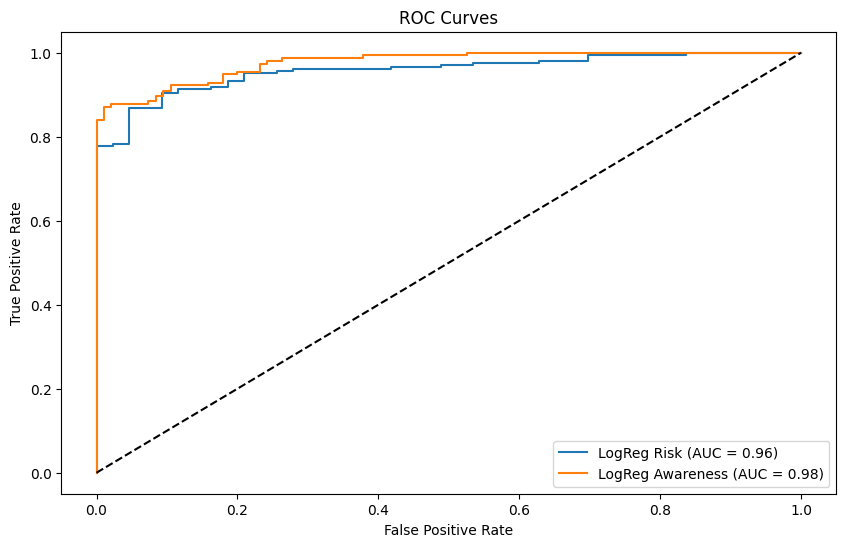

In [67]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

def tune_logistic(X_train, y_train):
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    grid = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

logreg_risk_best = tune_logistic(X_train_risk, y_train_risk)
logreg_aware_best = tune_logistic(X_train_aware, y_train_aware)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    cm = confusion_matrix(y_test, y_pred)
    print(f"{model_name} Confusion Matrix:")
    print(cm)
    return y_test, y_pred, y_prob

y_test_risk, y_pred_risk, y_prob_risk = evaluate_model(logreg_risk_best, X_test_risk, y_test_risk, "Logistic Regression - Risk")
y_test_aware, y_pred_aware, y_prob_aware = evaluate_model(logreg_aware_best, X_test_aware, y_test_aware, "Logistic Regression - Awareness")

def plot_roc(y_test, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.figure(figsize=(10,6))
plot_roc(y_test_risk, y_prob_risk, 'LogReg Risk')
plot_roc(y_test_aware, y_prob_aware, 'LogReg Awareness')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [68]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

def tune_logistic(X_train, y_train):
    logreg = LogisticRegression(max_iter=1000, random_state=42)
    grid = GridSearchCV(logreg, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

logreg_risk_best = tune_logistic(X_train_risk, y_train_risk)
logreg_aware_best = tune_logistic(X_train_aware, y_train_aware)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    return y_test, y_pred, y_prob

y_test_risk, y_pred_risk, y_prob_risk = evaluate_model(logreg_risk_best, X_test_risk, y_test_risk, "Logistic Regression - Risk")
y_test_aware, y_pred_aware, y_prob_aware = evaluate_model(logreg_aware_best, X_test_aware, y_test_aware, "Logistic Regression - Awareness")

def plot_roc(y_test, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')



Logistic Regression - Risk Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76        43
           1       0.95      0.96      0.95       207

    accuracy                           0.92       250
   macro avg       0.86      0.85      0.86       250
weighted avg       0.92      0.92      0.92       250

Accuracy: 0.9200

Logistic Regression - Awareness Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88        95
           1       0.95      0.88      0.92       155

    accuracy                           0.90       250
   macro avg       0.89      0.91      0.90       250
weighted avg       0.91      0.90      0.90       250

Accuracy: 0.9000


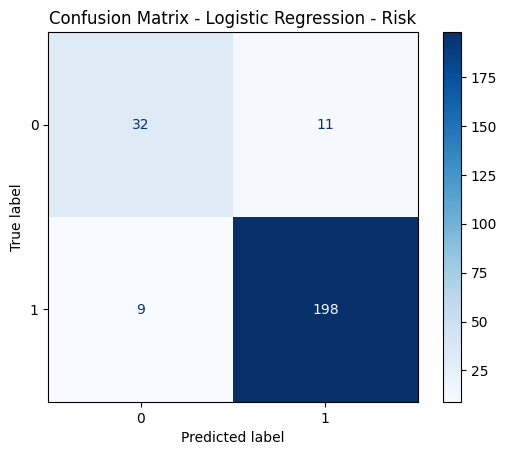

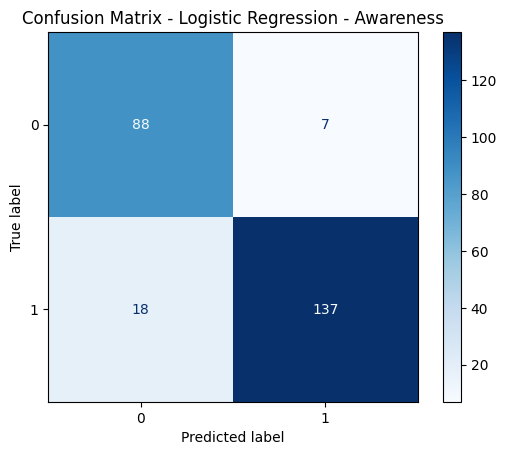

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

plot_confusion_matrix(y_test_risk, y_pred_risk, "Logistic Regression - Risk")
plot_confusion_matrix(y_test_aware, y_pred_aware, "Logistic Regression - Awareness")


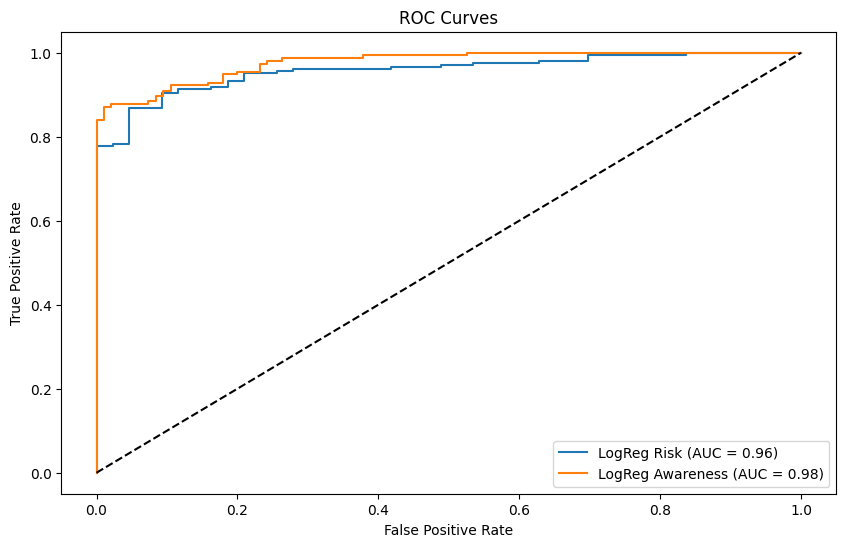

['scaler.joblib']

In [70]:
plt.figure(figsize=(10,6))
plot_roc(y_test_risk, y_prob_risk, 'LogReg Risk')
plot_roc(y_test_aware, y_prob_aware, 'LogReg Awareness')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

joblib.dump(logreg_risk_best, 'logreg_risk_model.joblib')
joblib.dump(logreg_aware_best, 'logreg_aware_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

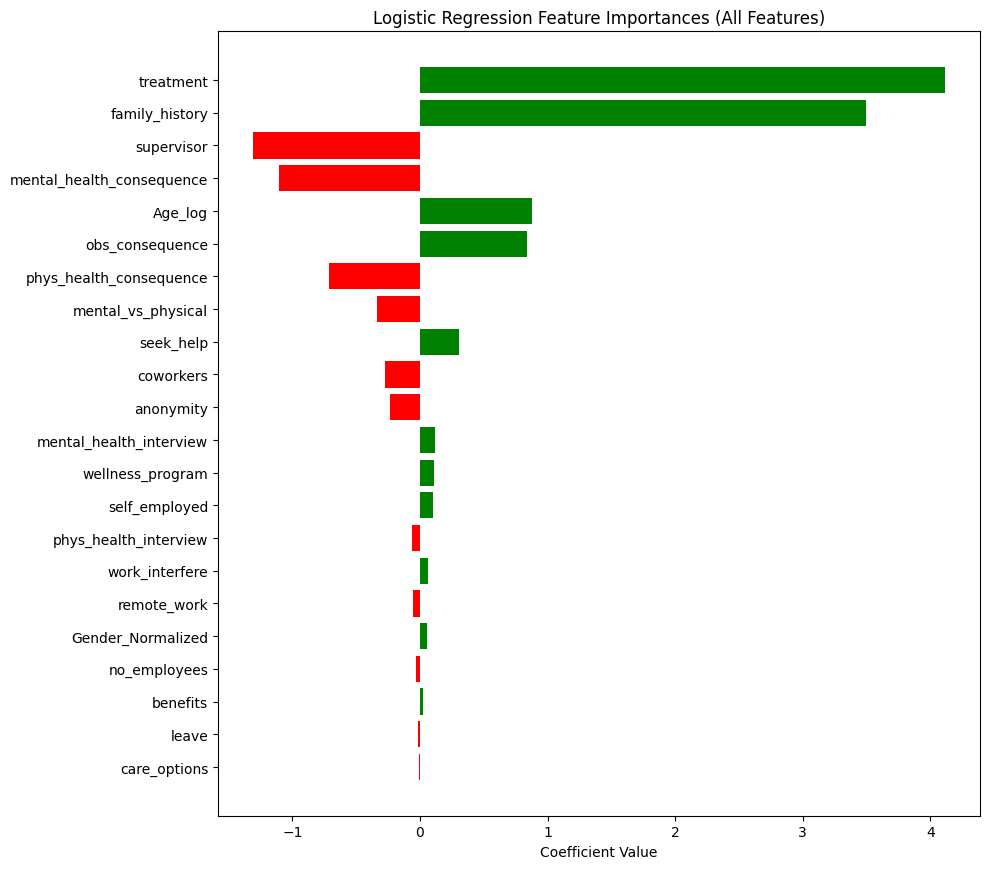

In [71]:
def plot_logreg_feature_importance_all(model, feature_names):
    coefs = model.coef_[0]
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs,
        'AbsCoefficient': np.abs(coefs)
    }).sort_values(by='AbsCoefficient', ascending=False)

    plt.figure(figsize=(10, len(coef_df) * 0.4))
    colors = ['green' if c > 0 else 'red' for c in coef_df['Coefficient']]
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
    plt.xlabel('Coefficient Value')
    plt.title('Logistic Regression Feature Importances (All Features)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

plot_logreg_feature_importance_all(logreg_risk_best, X.columns)
